In [1]:
%cd ..

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST


In [2]:
import torch
import pickle
from dataloaders import get_data_loaders
import matplotlib.pyplot as plt
from utils.log import load_checkpoint
from collections import defaultdict
from itertools import islice
from tqdm.notebook import tqdm
from models.Bipartite_Attention_bLRI import Bipartite_Attention as Model
from models.Bipartite_Attention_Masked import Bipartite_Attention as CModel
import matplotlib as mpl

import numpy as np

In [12]:
# α=0.7
config_file_path = 'train_results/biatt-augment-adj/experiment_2023-08-03_21:42:12/config.pkl'
with open(config_file_path, 'rb') as f:
    config = pickle.load(f)

In [13]:
dconfig = config['data']
train_data, val_data, test_data = get_data_loaders(**dconfig)

In [10]:
dconfig['use_']

{'add_geo_features': False,
 'batch_size': 512,
 'load_complete_graph': False,
 'n_test': 100000,
 'n_train': 500000,
 'n_valid': 100000,
 'n_workers': 16,
 'name': 'pred-tracks',
 'nontrigger_input_dir': '/ssd1/giorgian/data/alltrack/nontrigger/0',
 'rescale_by_percentile': 12,
 'trigger_input_dir': '/ssd1/giorgian/data/alltrack/trigger/1',
 'use_center': True,
 'use_energy': False,
 'use_momentum': False,
 'use_n_hits': False,
 'use_n_pixels': False,
 'use_parallel_momentum': False,
 'use_physics_pred': False,
 'use_predicted_pz': True,
 'use_radius': True,
 'use_transverse_momentum': False}

In [12]:
probabilities = defaultdict(list)
momentums = defaultdict(list)

In [13]:
N_BATCHES = 10
for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
    mask = torch.zeros(batch.track_vector.shape[:-1])
    for i, n in enumerate(batch.n_tracks):
        mask[i, :n] = 1
        
    mask = mask.to(DEVICE)
    track_vector = batch.track_vector.to(DEVICE)
    is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
    trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)
    p = batch.momentums.to(DEVICE)
    
    _, mask_logits = model(track_vector, mask)
    mask_probs = torch.softmax(mask_logits, dim=-1)[..., -1]
    mask = mask.to(torch.bool)
    probabilities[(0, 0)].extend(mask_probs[~trigger & ~is_trigger_track & mask])
    probabilities[(0, 1)].extend(mask_probs[~trigger & is_trigger_track & mask])
    probabilities[(1, 0)].extend(mask_probs[trigger & ~is_trigger_track & mask])
    probabilities[(1, 1)].extend(mask_probs[trigger & is_trigger_track & mask])
    
    momentums[(0, 0)].extend(p[~trigger & ~is_trigger_track & mask])
    momentums[(0, 1)].extend(p[~trigger & is_trigger_track & mask])
    momentums[(1, 0)].extend(p[trigger & ~is_trigger_track & mask])
    momentums[(1, 1)].extend(p[trigger & is_trigger_track & mask])  

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
for k, v in probabilities.items():
    if len(v) > 0:
        probabilities[k] = torch.stack(v).detach().cpu().numpy()
    else:
        print(f'{k} has no tracks.')

p_t = {}
for k, v in momentums.items():
    if len(v) > 0:
        p = torch.stack(v, dim=0)
        p_t[k] = torch.sqrt(p[:, 0]**2 + p[:, 1]**2).detach().cpu().numpy()
        momentums[k] = p.detach().cpu().numpy()
    else:
        print(f'{k} has no tracks.')

(0, 1) has no tracks.
(0, 1) has no tracks.


/tmp/ipykernel_3805978/982054865.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0, 0.5, 'Count')

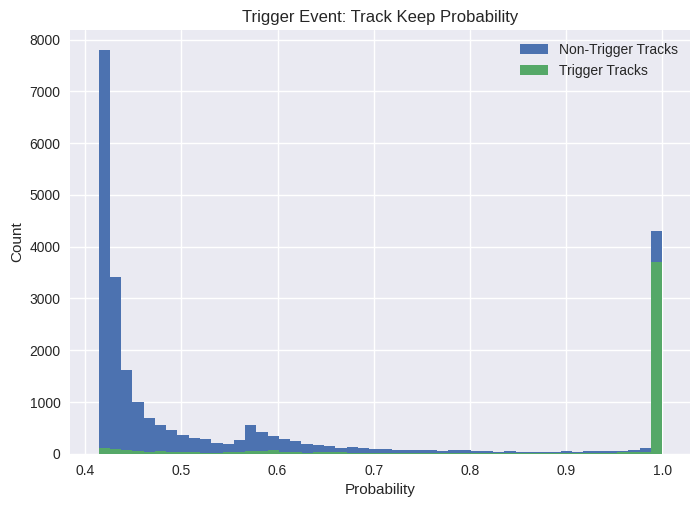

In [34]:
plt.style.use('ggplot')
plt.figure()
plt.hist(probabilities[(1, 0)], label='Non-Trigger Tracks', bins=50)
plt.hist(probabilities[(1, 1)], label='Trigger Tracks', bins=50)
plt.legend()
plt.title('Trigger Event: Track Keep Probability')
plt.xlabel('Probability')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

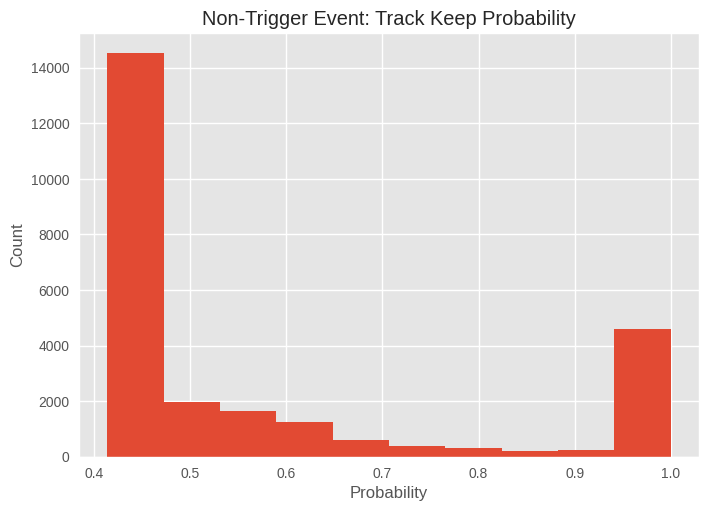

In [25]:
plt.figure()
plt.hist(probabilities[(1, 0)], label='Non-Trigger Tracks')
plt.title('Non-Trigger Event: Track Keep Probability')
plt.xlabel('Probability')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

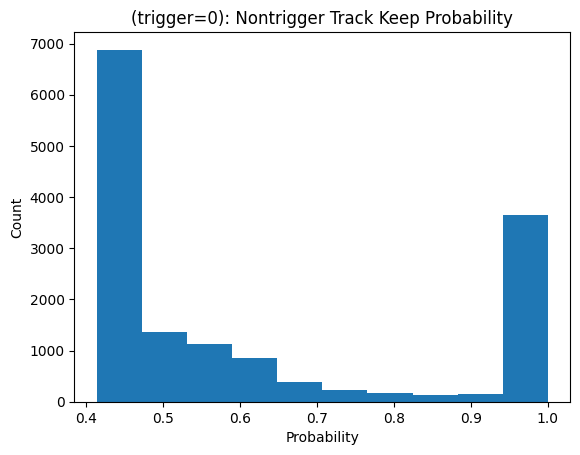

In [37]:
plt.figure()
plt.hist(probabilities[(0, 0)])
plt.title('(trigger=0): Nontrigger Track Keep Probability')
plt.xlabel('Probability')
plt.ylabel('Count')

Text(0, 0.5, 'Probability')

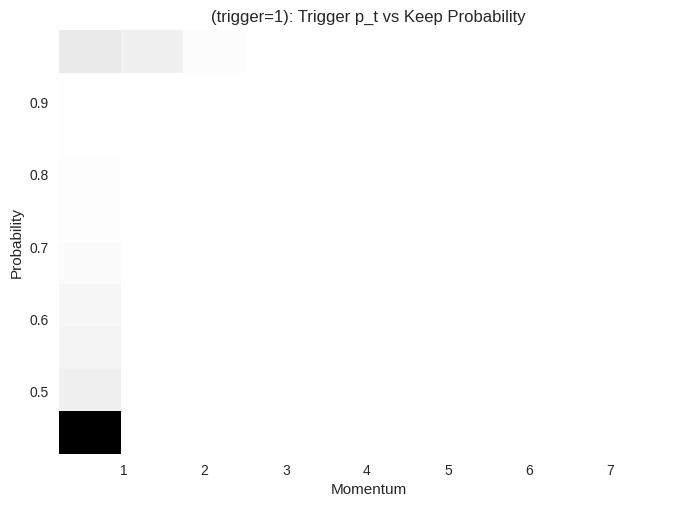

In [40]:
plt.figure()
#plt.scatter(p_t[(1, 1)], probabilities[(1, 1)])#, bins=30, norm=mpl.colors.LogNorm())
plt.hist2d(p_t[(1, 0)], probabilities[(1, 0)])#, bins=30, norm=mpl.colors.LogNorm())
plt.title('(trigger=1): Trigger p_t vs Keep Probability')
plt.xlabel('Momentum')
plt.ylabel('Probability')